## mcTEC similarity to c vs mTEC analysis 

In [2]:
import sys 
import os
from datetime import datetime

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
#import scvi
import hdf5plugin

import matplotlib.pyplot as plt
import seaborn as sns

# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = os.path.split(os.getcwd())[0]
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/lustre/scratch126/cellgen/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [5]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/lustre/scratch126/cellgen/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/data'

In [6]:
import celltypist

In [7]:
import seaborn as sns
import statannotations
import matplotlib
sns.__version__,statannotations.__version__,matplotlib.__version__

('0.13.2', '0.7.1', '3.10.0')

In [8]:
# Load data
adata = ad.read_h5ad(f'{data_path}/objects/thyAgeing_scvi_v3_2024-11-05_tec-fb-vascSplit_TEC_v4_2layers_400epochs_batch-sample2025-01-10.zarr')

new_obs = pd.read_csv(f'{data_path}/objects/thyAgeing_scvi_v3_2024-11-05_tec-fb-vascSplit_TEC_v4_2layers_400epochs_batch-sample_anno_2025-01-13.csv',
                     index_col = 0)

/tmp/ipykernel_2653176/1716162753.py:4: DtypeWarning: Columns (5,6,7,34,35,36,56) have mixed types. Specify dtype option on import or set low_memory=False.
  new_obs = pd.read_csv(f'{data_path}/objects/thyAgeing_scvi_v3_2024-11-05_tec-fb-vascSplit_TEC_v4_2layers_400epochs_batch-sample_anno_2025-01-13.csv',


In [9]:
adata.obs['taa_l5'] = new_obs.reindex(adata.obs_names)['TEC_anno'].copy()
adata = adata[~adata.obs['taa_l5'].isnull(),].copy()

... storing 'taa_l5' as categorical


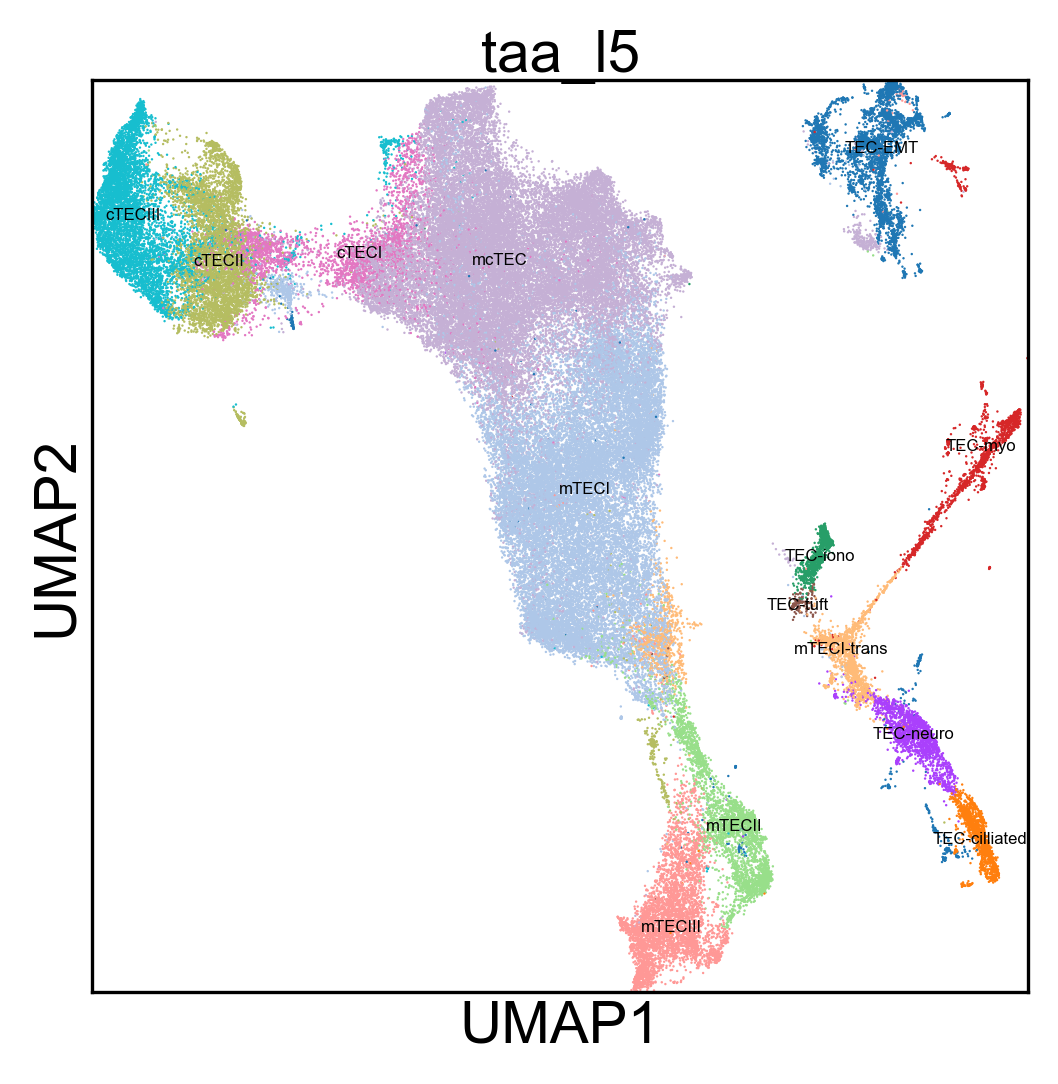

In [10]:
sc.pl.umap(adata, color = 'taa_l5', legend_loc = 'on data', legend_fontsize = 4)

In [12]:
from utils import update_obs
metafull = pd.read_excel(f'{general_data_path}/metadata/Thymus_ageing_metadata_v25_2025-01-28.xlsx')
ctype_hier = pd.read_excel(f'{general_data_path}/curated/thyAgeing_full_curatedAnno_v7_2025-02-05_levels.xlsx')

update_obs(adata, metafull, update_cols = ['age_group'], on = 'sample')
update_obs(adata, ctype_hier, update_cols = ['taa_l4', 'taa_l3', 'taa_l2', 'taa_l1','taa_l0'], on = 'taa_l5')

In [14]:
adata.obs['taa_l2'].value_counts()

taa_l2
mTEC       40470
mcTEC      29430
cTEC       15291
TEC-EMT     4519
Name: count, dtype: int64

## Train celltypist model without mcTECs

In [ ]:
def train_celltypist(adata_input, ctype_anno, name, path2save, downsample = False, gene_selection = ['hvg', 12000], 
                     celltypes = '', n_cells_ss = 10000, 
                     topGenes = 400, batch_hv = 'Age_group', 
                     main_markers = [], n_cells_train = 1000):
    import celltypist
    from datetime import datetime
    import time
    if celltypes:
        adata_input = adata_input[adata_input.obs[ctype_anno].isin(celltypes),:].copy()
    main_markers = [marker for marker in main_markers if marker in adata_input.var_names]
    if downsample:
        adata_train = downsample_adata_by_ctype(adata_input, ctype_anno, n_cells_ss)
    adata_train = adata_input.copy()
    print(f'Number of cells for gene selection {adata_train.shape[0]} and dropdown by celltypes {adata_train.obs[ctype_anno].value_counts()}')
    adata_train.layers['counts'] = adata_train.X.copy()
    if gene_selection[0] == 'hvg':
        print("Training on the highly variable genes:")
        sc.pp.highly_variable_genes(adata_train, flavor="seurat_v3", n_top_genes=gene_selection[1],
                                    layer="counts", batch_key=batch_hv)
        adata_train.var.loc[list(main_markers), 'highly_variable'] = True
        adata_train = adata_train[:, adata_train.var['highly_variable']].copy()
    elif gene_selection[0] == 'topMrkrs':
        print("Training on the top markers for each population:")
        genes = []
        counts = {}
        sc.pp.normalize_total(adata_train, target_sum=1e4)
        sc.pp.log1p(adata_train)
        sc.tl.rank_genes_groups(adata_train, groupby=ctype_anno)
        for ct in adata_train.obs[ctype_anno].unique():
            marker_genes = sc.get.rank_genes_groups_df(adata_train, ct, pval_cutoff=0.05, log2fc_min=0.5)
            counts[ct]= marker_genes.shape[0]
            if marker_genes.shape[0] > topGenes:
                genes += marker_genes['names'][0:gene_selection[1]].tolist()
            else:
                genes += marker_genes['names'].tolist()
        print(f'Gene selction using markers, picked {len(genes)} genes, see dropdown {counts}')
        adata_train = adata_train[:, adata_train.var_names.isin(genes+main_markers)].copy()
    else:
        print("Training on everything")

    sampled_cell_index = celltypist.samples.downsample_adata(adata_train, mode = 'each', n_cells = n_cells_train,
                                                             by = ctype_anno, return_index = True)
    adata_train.X = adata_train.layers['counts'].copy()
    sc.pp.normalize_total(adata_train, target_sum=1e4)
    sc.pp.log1p(adata_train)
    print(f'Training celltypist on the data with {len(sampled_cell_index)} cells and {adata_train.shape[1]} genes')
    today = datetime.today().strftime('%Y-%m-%d')
    t_start = time.time()
    model = celltypist.train(adata_train[sampled_cell_index, :], ctype_anno, check_expression = True, \
                             n_jobs = 4, max_iter = 200)
    t_end = time.time()
    print(f"Time elapsed: {(t_end - t_start)/60} minutes")
    model.write(f"{path2save}Celltypist_mod_{name}_{today}.pkl")
    print(f"Celltypist_mod_{name}_{today}.pkl is written")


In [33]:
train_celltypist(adata_input = adata, ctype_anno = 'taa_l2', name = 'TEC_taa_l2_nomcTEC', 
                 path2save = f'{model_path}/',gene_selection ='hvg', 
                 celltypes = ['cTEC', 'mTEC', 'TEC-EMT'], n_cells_ss = 10000, 
                     topGenes = 400, batch_hv = 'age_group', 
                     main_markers = [], n_cells_train = 1000)

Number of cells for gene selection 24519 and drowdown by celltypes taa_l2
mTEC       10000
cTEC       10000
TEC-EMT     4519
Name: count, dtype: int64


🍳 Preparing data before training


Training celltypist on the data with 3000 cells and 12000 genes


✂️ 1049 non-expressed genes are filtered out
🔬 Input data has 3000 cells and 10951 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


Time elapsed: 0.07095235586166382 minutes
Celltypist_mod_TEC_taa_l2_nomcTEC_2025-02-23.pkl is written


In [15]:
from celltypist import models

In [16]:
taa_l2_model = models.Model.load(f'{model_path}/Celltypist_mod_TEC_taa_l2_nomcTEC_2025-02-23.pkl')

In [17]:
from utils_vk8 import ctypist_anno

def ctypist_anno(adata, model, col_name, mv = False, clusters = None):
    predictions = celltypist.annotate(adata, model=model, majority_voting = mv, over_clustering = clusters)
    predictions.to_adata(prefix=f'ctypist_{col_name}_')
    if mv:
        sc.pl.umap(adata, color = f'ctypist_{col_name}_majority_voting', frameon = False)
    else:
        sc.pl.umap(adata, color = f'ctypist_{col_name}_predicted_labels', frameon = False)

🔬 Input data has 89710 cells and 35530 genes
🔗 Matching reference genes in the model
🧬 10951 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
... storing 'sample' as categorical
... storing 'age_group' as categorical
... storing 'taa_l5' as categorical
... storing 'taa_l4' as categorical
... storing 'taa_l3' as categorical
... storing 'taa_l2' as categorical
... storing 'taa_l1' as categorical
... storing 'taa_l0' as categorical


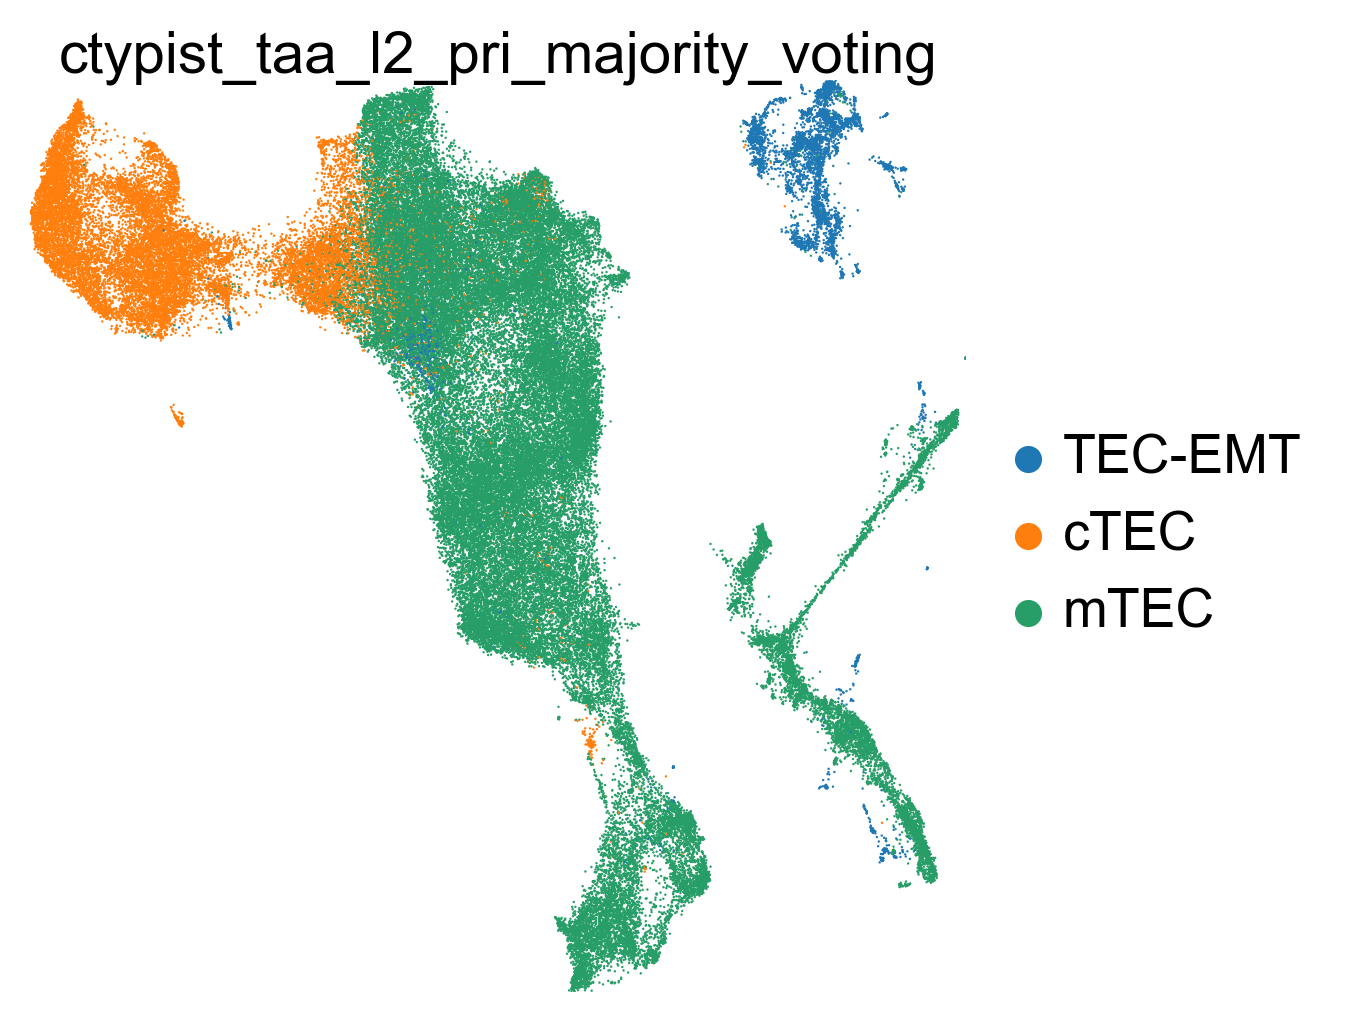

In [18]:
ctypist_anno(adata, model = taa_l2_model, col_name = 'taa_l2_pri', mv = True)

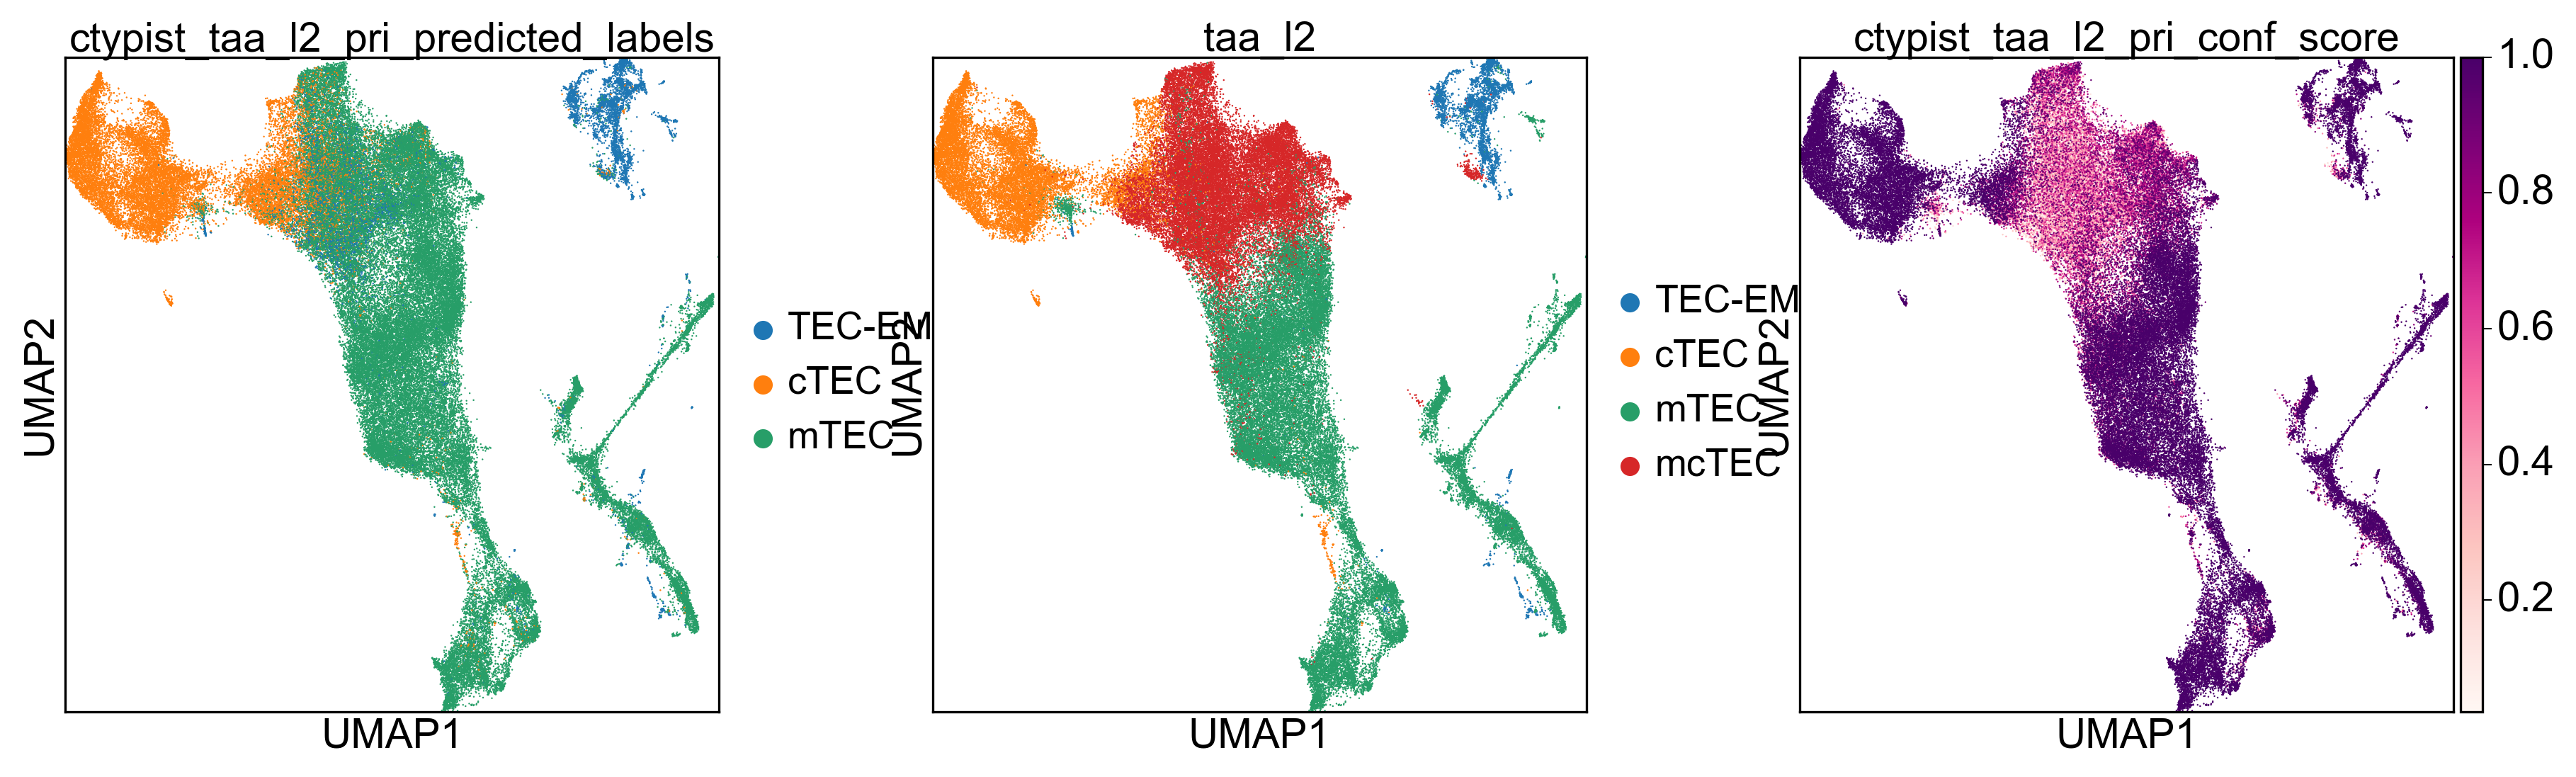

In [19]:
sc.pl.umap(adata, color = ['ctypist_taa_l2_pri_predicted_labels', 'taa_l2', 'ctypist_taa_l2_pri_conf_score'])

In [20]:
adata.obs['pri_anno'] = adata.obs.apply(lambda x: 'cTEC-pri' if ((x['taa_l2'] == 'mcTEC') & (x['ctypist_taa_l2_pri_predicted_labels'] == 'cTEC') & (x['ctypist_taa_l2_pri_conf_score'] >0.5)) else
                                       'mTEC-pri' if ((x['taa_l2'] == 'mcTEC') & (x['ctypist_taa_l2_pri_predicted_labels'] == 'mTEC') & (x['ctypist_taa_l2_pri_conf_score'] >0.5)) else
                                        'EMT-pri' if ((x['taa_l2'] == 'mcTEC') & (x['ctypist_taa_l2_pri_predicted_labels'] == 'TEC-EMT') & (x['ctypist_taa_l2_pri_conf_score'] >0.5)) else
                                       'unpri' if ((x['taa_l2'] == 'mcTEC') & (x['ctypist_taa_l2_pri_conf_score'] <0.5)) else x['taa_l2'], axis = 1)

... storing 'pri_anno' as categorical


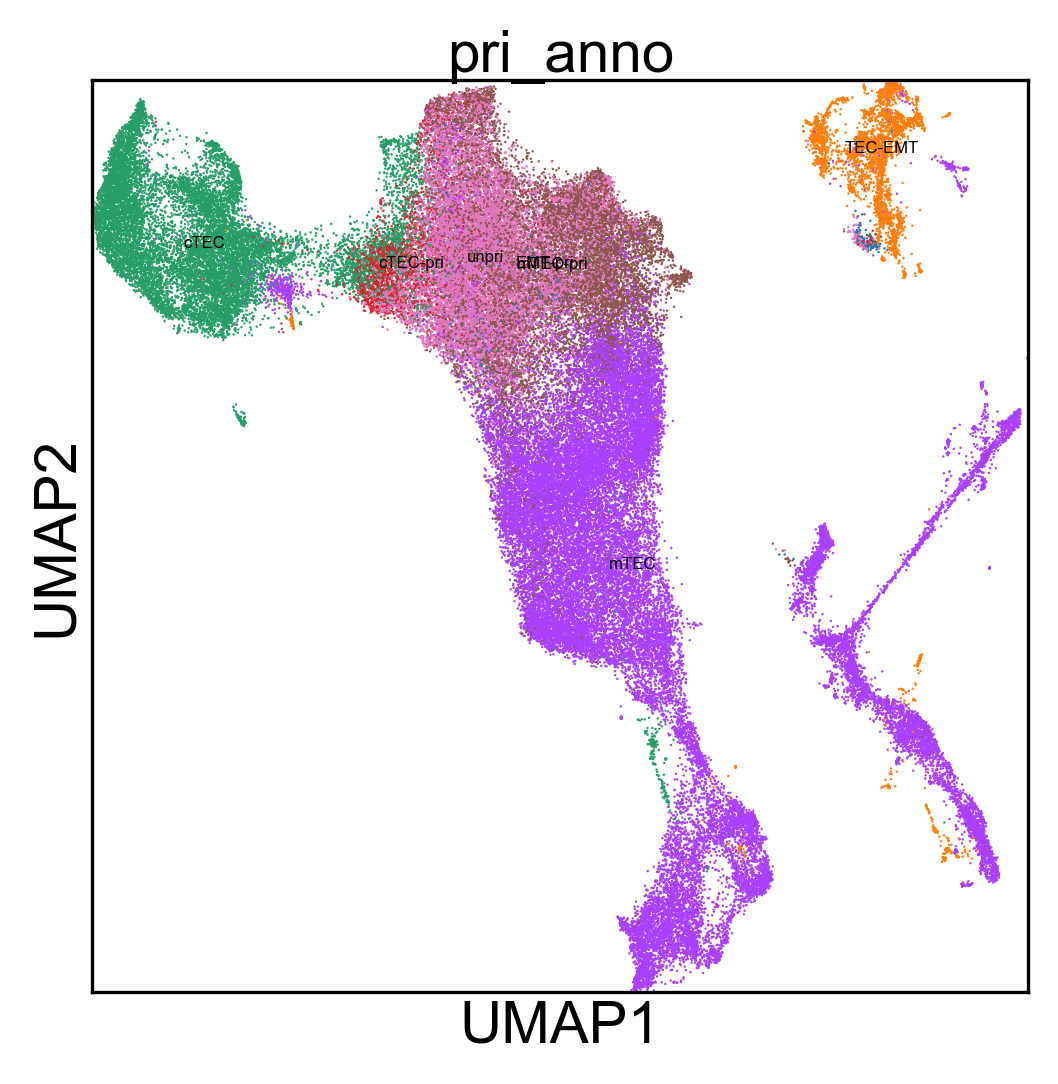

In [21]:
sc.pl.umap(adata, color = 'pri_anno', legend_loc = 'on data', legend_fontsize = 4)

In [50]:
adata.obs[['pri_anno']].to_csv(f'{data_path}/objects/thyAgeing_prianno_2025-02-28.csv')